# Reynolds watershed

In [1]:
watershed = 'Reynolds'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/25-ReynoldsCreek'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Streamflow

In [4]:
siteList = ['036','046','057','098','116b','117','125b','135','138012','166']

In [5]:
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('http://reynoldscreekczo.org/rcewdata/streamflow/reynolds-creek-'+i+'-hourly-streamflow.dat', 
                   header = 0,index_col = 'datetime',
                     parse_dates = True, skiprows=17,
                   infer_datetime_format = True)
    data = data.iloc[:len(data)-2]
    data.index = pd.to_datetime(data.index)  
    data.columns = [i+'_Discharge']
    data=threC(data,'Discharge')
    display(data.head(2))
    df_lst.append(data)

036


036_Discharge
datetime                          
1963-01-01 00:00:00       0.068408
1963-01-01 01:00:00       0.065833

046


046_Discharge
datetime                          
1964-01-29 00:00:00        0.01655
1964-01-29 01:00:00        0.01655

057


057_Discharge
datetime                          
1972-01-15 00:00:00            0.0
1972-01-15 01:00:00            0.0

098


098_Discharge
datetime                          
1971-12-20 00:00:00            0.0
1971-12-20 01:00:00            0.0

116b


116b_Discharge
datetime                           
1966-03-29 02:00:00        0.562107
1966-03-29 03:00:00        0.533079

117


117_Discharge
datetime                          
1966-03-07 00:00:00            0.0
1966-03-07 01:00:00            0.0

125b


125b_Discharge
datetime                           
2003-03-17 10:00:00         0.00592
2003-03-17 11:00:00         0.00592

135


135_Discharge
datetime                          
1973-01-01 00:00:00        0.05845
1973-01-01 01:00:00        0.05845

138012


138012_Discharge
datetime                             
1970-02-20 00:00:00               0.0
1970-02-20 01:00:00               0.0

166


166_Discharge
datetime                          
1963-01-01 00:00:00       0.000233
1963-01-01 01:00:00       0.000239

In [6]:
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

['057_Discharge', datetime.date(1980, 1, 1)]
nan ratio is 0.041666666666666664 , groupby value is 5.502817565217391e-08
['057_Discharge', datetime.date(1984, 2, 14)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['057_Discharge', datetime.date(1986, 1, 8)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['098_Discharge', datetime.date(1972, 3, 4)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['098_Discharge', datetime.date(1975, 2, 11)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['098_Discharge', datetime.date(1976, 2, 17)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['098_Discharge', datetime.date(1987, 12, 10)]
nan ratio is 0.041666666666666664 , groupby value is 2.0013089130434784e-07
['098_Discharge', datetime.date(2001, 2, 19)]
nan ratio is 0.041666666666666664 , groupby value is 1.44588e-06
['098_Discharge', datetime.date(2005, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 4.0518391304347827e-08
['098_Disc

036_Discharge 046_Discharge 057_Discharge 098_Discharge  \
1963-01-01     0.0762129           NaN           NaN           NaN   
1963-01-02     0.0853856           NaN           NaN           NaN   

           116b_Discharge 117_Discharge 125b_Discharge 135_Discharge  \
1963-01-01            NaN           NaN            NaN           NaN   
1963-01-02            NaN           NaN            NaN           NaN   

           138012_Discharge 166_Discharge  
1963-01-01              NaN    0.00026455  
1963-01-02              NaN    0.00023348

036_Discharge 046_Discharge 057_Discharge 098_Discharge  \
2014-12-30      0.237029           NaN           NaN           NaN   
2014-12-31      0.237029           NaN           NaN           NaN   

           116b_Discharge 117_Discharge 125b_Discharge 135_Discharge  \
2014-12-30       0.101135           NaN      0.0036265      0.033407   
2014-12-31      0.0957747           NaN     0.00333577     0.0292017   

           138012_Discharge 166_Discharge  
2014-12-30              NaN    0.00155353  
2014-12-31              NaN    0.00149425

036_Discharge
046_Discharge
057_Discharge
098_Discharge
116b_Discharge
117_Discharge
125b_Discharge
135_Discharge
138012_Discharge
166_Discharge


036_Discharge  046_Discharge  057_Discharge  098_Discharge  \
1963-01-01      58.493652      17.518692            NaN            NaN   
1963-01-02      85.385588            NaN            NaN            NaN   
1963-01-03      92.397028            NaN            NaN            NaN   
1963-01-04      75.249791            NaN            NaN            NaN   
1963-01-05      56.844037            NaN            NaN            NaN   

            116b_Discharge  117_Discharge  125b_Discharge  135_Discharge  \
1963-01-01       35.796347       0.000262             NaN            NaN   
1963-01-02             NaN            NaN             NaN            NaN   
1963-01-03             NaN            NaN             NaN            NaN   
1963-01-04             NaN            NaN             NaN            NaN   
1963-01-05             NaN            NaN             NaN            NaN   

            138012_Discharge  166_Discharge  
1963-01-01               NaN       0.414160  
1963-01-02               NaN       0.233480  
1963-01-03               NaN       0.295193  
1963-01-04               NaN       0.283894  
1963-01-05               NaN       2.467003

<Figure size 720x288 with 0 Axes>

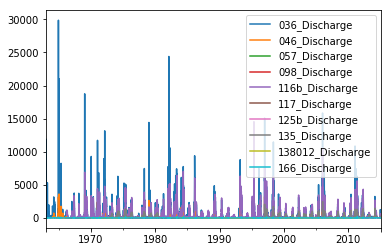

In [7]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] * 1000 # m3/s to L/s
                       
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head()

### Hydrometeorology

### 2. Precipitation

In [8]:
# stations
siteList = ['012','031','049','057','076','095b','098c',
           '116c','124','124b','125','127','13803','138j10',
           '144','145','147','155','163',
           '167','174','176','rmsp3']
df_lst=[]
for i in siteList:
    data = pd.read_csv('http://reynoldscreekczo.org/rcewdata/precipitation/reynolds-creek-'+i+'-hourly-precipitation.dat', 
                   header = 0,index_col = 'datetime',
                     parse_dates = True, skiprows=19,
                   infer_datetime_format = True)
    data = data.iloc[:len(data)-2]
    data.index = pd.to_datetime(data.index)
    data = data[['ppta']] #### need to check which one to use 
    data.columns = [i+'_Precipitation']
    data = threC(data,'Precipitation')
    display(data.head(2))
    df_lst.append(data)
    
# station: 138121
print('138121')
data = pd.read_csv('http://reynoldscreekczo.org/rcewdata/precipitation/reynolds-creek-138l21-hourly-precipitation.dat',
                   header = 0,index_col = 'datetime',
                     parse_dates = True, skiprows=19,
                   infer_datetime_format = True)
data = data.iloc[:len(data)-2]
data.index = pd.to_datetime(data.index)
data1 = copy.deepcopy(data[['ppta']])
data1.columns = ['138121_Precipitation']
data1 = threC(data1,'Precipitation')
df_lst.append(data1)

# station: 166b
print('166b')
data = pd.read_csv('http://reynoldscreekczo.org/rcewdata/precipitation/reynolds-creek-166b-hourly-precipitation.dat',
                   header = 0,index_col = 'datetime',
                     parse_dates = True, skiprows=19,
                   infer_datetime_format = True)
data = data.iloc[:len(data)-2]
data.index = pd.to_datetime(data.index)
data2 = copy.deepcopy(data[['ppta']])
data2.columns =['166b_Precipitation']
data2 = threC(data2,'Precipitation')
df_lst.append(data2)

012_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

031_Precipitation
datetime                              
1968-01-01 01:00:00                0.0
1968-01-01 02:00:00                0.0

049_Precipitation
datetime                              
1965-01-01 01:00:00                0.0
1965-01-01 02:00:00                0.0

057_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

076_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

095b_Precipitation
datetime                               
1962-01-01 01:00:00                 0.0
1962-01-01 02:00:00                 0.0

098c_Precipitation
datetime                               
1972-01-01 01:00:00                 0.0
1972-01-01 02:00:00                 0.0

116c_Precipitation
datetime                               
1962-01-01 01:00:00                 0.0
1962-01-01 02:00:00                 0.0

124_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

124b_Precipitation
datetime                               
2006-10-31 13:00:00                 NaN
2006-10-31 14:00:00                 NaN

125_Precipitation
datetime                              
2002-06-26 08:00:00                0.0
2002-06-26 09:00:00                0.0

127_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

13803_Precipitation
datetime                                
1983-01-01 01:00:00                  NaN
1983-01-01 02:00:00                  NaN

138j10_Precipitation
datetime                                 
1983-01-01 01:00:00                   NaN
1983-01-01 02:00:00                   NaN

144_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

145_Precipitation
datetime                              
1965-01-01 01:00:00                0.0
1965-01-01 02:00:00                0.0

147_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

155_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

163_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

167_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

174_Precipitation
datetime                              
1962-01-01 01:00:00                0.0
1962-01-01 02:00:00                0.0

176_Precipitation
datetime                              
1968-01-01 01:00:00                0.0
1968-01-01 02:00:00                0.0

rmsp3_Precipitation
datetime                                
1962-01-01 01:00:00                  0.0
1962-01-01 02:00:00                  0.0

138121
166b


In [9]:
prep=aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

['049_Precipitation', datetime.date(1979, 8, 7)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['076_Precipitation', datetime.date(2006, 12, 31)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['098c_Precipitation', datetime.date(1980, 10, 8)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['147_Precipitation', datetime.date(2006, 12, 31)]
nan ratio is 0.08333333333333333 , groupby value is 0.0
['163_Precipitation', datetime.date(2006, 12, 31)]
nan ratio is 0.08333333333333333 , groupby value is 0.0
['167_Precipitation', datetime.date(2006, 12, 31)]
nan ratio is 0.08333333333333333 , groupby value is 0.0
The final table is:


012_Precipitation 031_Precipitation 049_Precipitation  \
1962-01-01                 0               NaN               NaN   
1962-01-02                 0               NaN               NaN   

           057_Precipitation 076_Precipitation 095b_Precipitation  \
1962-01-01                 0                 0                  0   
1962-01-02                 0                 0                  0   

           098c_Precipitation 116c_Precipitation 124_Precipitation  \
1962-01-01                NaN                  0                 0   
1962-01-02                NaN                  0                 0   

           124b_Precipitation  ... 145_Precipitation 147_Precipitation  \
1962-01-01                NaN  ...               NaN                 0   
1962-01-02                NaN  ...               NaN                 0   

           155_Precipitation 163_Precipitation 167_Precipitation  \
1962-01-01                 0                 0                 0   
1962-01-02                 0                 0                 0   

           174_Precipitation 176_Precipitation rmsp3_Precipitation  \
1962-01-01                 0               NaN                   0   
1962-01-02                 0               NaN                   0   

           138121_Precipitation 166b_Precipitation  
1962-01-01                  NaN                NaN  
1962-01-02                  NaN                NaN  

[2 rows x 25 columns]

012_Precipitation 031_Precipitation 049_Precipitation  \
2014-12-30                 0               0.3                 0   
2014-12-31                 0                 0                 0   

           057_Precipitation 076_Precipitation 095b_Precipitation  \
2014-12-30                 0                 0                0.9   
2014-12-31                 0                 0                  0   

           098c_Precipitation 116c_Precipitation 124_Precipitation  \
2014-12-30                  0                0.9               0.5   
2014-12-31                  0                0.1                 0   

           124b_Precipitation  ... 145_Precipitation 147_Precipitation  \
2014-12-30                NaN  ...               4.4                 0   
2014-12-31                NaN  ...                 0               4.7   

           155_Precipitation 163_Precipitation 167_Precipitation  \
2014-12-30               1.4               0.5                 1   
2014-12-31                 0                 0               1.4   

           174_Precipitation 176_Precipitation rmsp3_Precipitation  \
2014-12-30               2.2               1.3                 1.1   
2014-12-31                 0                 0                   0   

           138121_Precipitation 166b_Precipitation  
2014-12-30                    0                NaN  
2014-12-31                    0                NaN  

[2 rows x 25 columns]

012_Precipitation
031_Precipitation
049_Precipitation
057_Precipitation
076_Precipitation
095b_Precipitation
098c_Precipitation
116c_Precipitation
124_Precipitation
124b_Precipitation
125_Precipitation
127_Precipitation
13803_Precipitation
138j10_Precipitation
144_Precipitation
145_Precipitation
147_Precipitation
155_Precipitation
163_Precipitation
167_Precipitation
174_Precipitation
176_Precipitation
rmsp3_Precipitation
138121_Precipitation
166b_Precipitation


012_Precipitation  031_Precipitation  049_Precipitation  \
1962-01-01                0.0                0.0                0.0   
1962-01-02                0.0                NaN                NaN   
1962-01-03                0.0                NaN                NaN   
1962-01-04                0.0                NaN                NaN   
1962-01-05                0.0                NaN                NaN   

            057_Precipitation  076_Precipitation  095b_Precipitation  \
1962-01-01                0.0                0.0                 0.0   
1962-01-02                0.0                0.0                 0.0   
1962-01-03                0.0                0.0                 0.0   
1962-01-04                0.0                0.0                 0.0   
1962-01-05                0.0                0.0                 0.0   

            098c_Precipitation  116c_Precipitation  124_Precipitation  \
1962-01-01                 NaN                 0.0                0.0   
1962-01-02                 NaN                 0.0                0.0   
1962-01-03                 NaN                 0.0                0.0   
1962-01-04                 NaN                 0.0                0.0   
1962-01-05                 NaN                 0.0                0.0   

            124b_Precipitation  ...  145_Precipitation  147_Precipitation  \
1962-01-01                 NaN  ...                0.0                0.0   
1962-01-02                 NaN  ...                NaN                0.0   
1962-01-03                 NaN  ...                NaN                0.0   
1962-01-04                 NaN  ...                NaN                0.0   
1962-01-05                 NaN  ...                NaN                0.0   

            155_Precipitation  163_Precipitation  167_Precipitation  \
1962-01-01                0.0                0.0                0.0   
1962-01-02                0.0                0.0                0.0   
1962-01-03                0.0                0.0                0.0   
1962-01-04                0.0                0.0                0.0   
1962-01-05                0.0                0.0                0.0   

            174_Precipitation  176_Precipitation  rmsp3_Precipitation  \
1962-01-01                0.0                0.9                  0.0   
1962-01-02                0.0                NaN                  0.0   
1962-01-03                0.0                NaN                  0.0   
1962-01-04                0.0                NaN                  0.0   
1962-01-05                0.0                NaN                  0.0   

            138121_Precipitation  166b_Precipitation  
1962-01-01                   NaN                 NaN  
1962-01-02                   NaN                 NaN  
1962-01-03                   NaN                 NaN  
1962-01-04                   NaN                 NaN  
1962-01-05                   NaN                 NaN  

[5 rows x 25 columns]

<Figure size 720x288 with 0 Axes>

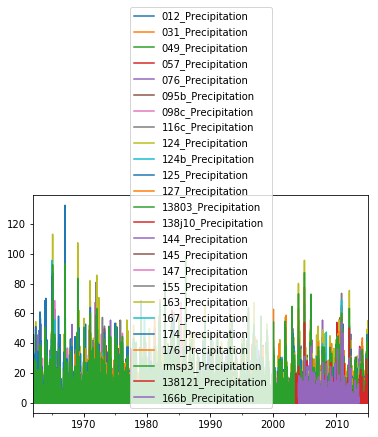

In [10]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
Precipitation = copy.deepcopy(df)
Precipitation.plot()
Precipitation.head()

### 3. AirTemperature 

In [11]:
siteList = ['124','124b','125','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b','jdt5']

In [12]:
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/weather_data_'+i+'.csv', 
                        header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    data = data[['T_a']] #### need to check which one to use 
    data.columns = [i+'_AirTemperature']    
    data = threC(data,'AirTemperature')
    df_lst.append(data)    

124
124b
125
jdt1
jdt2
jdt2b
jdt3
jdt3b
jdt4
jdt4b
jdt5


In [13]:
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

['125_AirTemperature', datetime.date(2009, 12, 8)]
nan ratio is 0.041666666666666664 , groupby value is -15.673913043478262
['jdt1_AirTemperature', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 18.969565217391303
['jdt1_AirTemperature', datetime.date(2010, 8, 19)]
nan ratio is 0.041666666666666664 , groupby value is 21.747826086956522
['jdt1_AirTemperature', datetime.date(2014, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is 4.1695652173913045
['jdt2_AirTemperature', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 18.713043478260875
['jdt3_AirTemperature', datetime.date(2010, 6, 26)]
nan ratio is 0.08333333333333333 , groupby value is 17.204545454545453
['jdt3_AirTemperature', datetime.date(2010, 9, 30)]
nan ratio is 0.08333333333333333 , groupby value is 20.504545454545454
['jdt3b_AirTemperature', datetime.date(2010, 12, 23)]
nan ratio is 0.041666666666666664 , groupby value is 0.6652173913043479
['jdt3b_

124_AirTemperature 124b_AirTemperature 125_AirTemperature  \
2003-10-01            18.7625              18.375            18.3917   
2003-10-02            15.4417              15.475            16.8417   

           jdt1_AirTemperature jdt2_AirTemperature jdt2b_AirTemperature  \
2003-10-01                 NaN                 NaN                  NaN   
2003-10-02                 NaN                 NaN                  NaN   

           jdt3_AirTemperature jdt3b_AirTemperature jdt4_AirTemperature  \
2003-10-01                 NaN                  NaN                 NaN   
2003-10-02                 NaN                  NaN                 NaN   

           jdt4b_AirTemperature jdt5_AirTemperature  
2003-10-01                  NaN                 NaN  
2003-10-02                  NaN                 NaN

124_AirTemperature 124b_AirTemperature 125_AirTemperature  \
2014-09-30            6.82083              7.2875            9.33333   
2014-10-01                NaN                 NaN                NaN   

           jdt1_AirTemperature jdt2_AirTemperature jdt2b_AirTemperature  \
2014-09-30             9.37083             8.28333              8.74583   
2014-10-01                   5                 4.5                  4.1   

           jdt3_AirTemperature jdt3b_AirTemperature jdt4_AirTemperature  \
2014-09-30                8.25              8.52917             8.09167   
2014-10-01                 4.5                  3.7                 4.5   

           jdt4b_AirTemperature jdt5_AirTemperature  
2014-09-30              7.84167             7.74167  
2014-10-01                  3.1                 3.4

124_AirTemperature
124b_AirTemperature
125_AirTemperature
jdt1_AirTemperature
jdt2_AirTemperature
jdt2b_AirTemperature
jdt3_AirTemperature
jdt3b_AirTemperature
jdt4_AirTemperature
jdt4b_AirTemperature
jdt5_AirTemperature


124_AirTemperature  124b_AirTemperature  125_AirTemperature  \
2003-10-01           18.762500            18.375000           18.391667   
2003-10-02           15.441667            15.475000           16.841667   
2003-10-03           14.579167            14.745833           15.550000   
2003-10-04           16.016667            15.441667           15.454167   
2003-10-05           16.795833            15.683333           16.570833   

            jdt1_AirTemperature  jdt2_AirTemperature  jdt2b_AirTemperature  \
2003-10-01                  NaN                  NaN                   NaN   
2003-10-02                  NaN                  NaN                   NaN   
2003-10-03                  NaN                  NaN                   NaN   
2003-10-04                  NaN                  NaN                   NaN   
2003-10-05                  NaN                  NaN                   NaN   

            jdt3_AirTemperature  jdt3b_AirTemperature  jdt4_AirTemperature  \
2003-10-01                  NaN                   NaN                  NaN   
2003-10-02                  NaN                   NaN                  NaN   
2003-10-03                  NaN                   NaN                  NaN   
2003-10-04                  NaN                   NaN                  NaN   
2003-10-05                  NaN                   NaN                  NaN   

            jdt4b_AirTemperature  jdt5_AirTemperature  
2003-10-01                   NaN                  NaN  
2003-10-02                   NaN                  NaN  
2003-10-03                   NaN                  NaN  
2003-10-04                   NaN                  NaN  
2003-10-05                   NaN                  NaN

<Figure size 720x288 with 0 Axes>

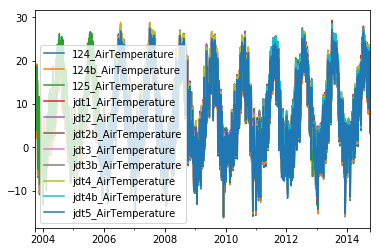

In [14]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head()

### 4. SolarRadiation
### None

### 5. RelativeHumidity

In [15]:
siteList = ['124b','125','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b','jdt5']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/weather_data_'+i+'.csv', 
                        header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
    #data = data.iloc[:len(data)-2]
    data.index = pd.to_datetime(data.index)
    data = data[['RH']] #### need to check which one to use 
    data.columns = [i+'_RelativeHumidity']   
    data = threC(data,'RelativeHumidity')
    df_lst.append(data)  

124b
125
jdt1
jdt2
jdt2b
jdt3
jdt3b
jdt4
jdt4b
jdt5


In [16]:
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

['jdt1_RelativeHumidity', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.4034782608695653
['jdt1_RelativeHumidity', datetime.date(2010, 8, 19)]
nan ratio is 0.041666666666666664 , groupby value is 0.23521739130434788
['jdt1_RelativeHumidity', datetime.date(2014, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is 0.8739130434782608
['jdt2_RelativeHumidity', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.3865217391304348
['jdt3_RelativeHumidity', datetime.date(2010, 6, 26)]
nan ratio is 0.08333333333333333 , groupby value is 0.5
['jdt3_RelativeHumidity', datetime.date(2010, 9, 30)]
nan ratio is 0.08333333333333333 , groupby value is 0.22681818181818186
['jdt4_RelativeHumidity', datetime.date(2009, 8, 21)]
nan ratio is 0.08333333333333333 , groupby value is 0.2513636363636364
['jdt4_RelativeHumidity', datetime.date(2009, 9, 3)]
nan ratio is 0.041666666666666664 , groupby value is 0.20173913043478264
['jdt4_R

124b_RelativeHumidity 125_RelativeHumidity jdt1_RelativeHumidity  \
2003-10-01              0.293333               0.2975                   NaN   
2003-10-02              0.448333              0.41375                   NaN   

           jdt2_RelativeHumidity jdt2b_RelativeHumidity jdt3_RelativeHumidity  \
2003-10-01                   NaN                    NaN                   NaN   
2003-10-02                   NaN                    NaN                   NaN   

           jdt3b_RelativeHumidity jdt4_RelativeHumidity  \
2003-10-01                    NaN                   NaN   
2003-10-02                    NaN                   NaN   

           jdt4b_RelativeHumidity jdt5_RelativeHumidity  
2003-10-01                    NaN                   NaN  
2003-10-02                    NaN                   NaN

124b_RelativeHumidity 125_RelativeHumidity jdt1_RelativeHumidity  \
2014-09-30              0.747083              0.71125              0.677917   
2014-10-01                   NaN                  NaN                  0.73   

           jdt2_RelativeHumidity jdt2b_RelativeHumidity jdt3_RelativeHumidity  \
2014-09-30                0.6725                0.67625              0.681667   
2014-10-01                  0.71                   0.74                  0.71   

           jdt3b_RelativeHumidity jdt4_RelativeHumidity  \
2014-09-30               0.688333                0.6975   
2014-10-01                   0.76                  0.72   

           jdt4b_RelativeHumidity jdt5_RelativeHumidity  
2014-09-30               0.699583              0.723333  
2014-10-01                   0.77                  0.78

124b_RelativeHumidity
125_RelativeHumidity
jdt1_RelativeHumidity
jdt2_RelativeHumidity
jdt2b_RelativeHumidity
jdt3_RelativeHumidity
jdt3b_RelativeHumidity
jdt4_RelativeHumidity
jdt4b_RelativeHumidity
jdt5_RelativeHumidity


124b_RelativeHumidity  125_RelativeHumidity  \
2003-10-01              29.333333             29.750000   
2003-10-02              44.833333             41.375000   
2003-10-03              56.333333             53.083333   
2003-10-04              51.083333             51.791667   
2003-10-05              46.625000             44.791667   

            jdt1_RelativeHumidity  jdt2_RelativeHumidity  \
2003-10-01                    NaN                    NaN   
2003-10-02                    NaN                    NaN   
2003-10-03                    NaN                    NaN   
2003-10-04                    NaN                    NaN   
2003-10-05                    NaN                    NaN   

            jdt2b_RelativeHumidity  jdt3_RelativeHumidity  \
2003-10-01                     NaN                    NaN   
2003-10-02                     NaN                    NaN   
2003-10-03                     NaN                    NaN   
2003-10-04                     NaN                    NaN   
2003-10-05                     NaN                    NaN   

            jdt3b_RelativeHumidity  jdt4_RelativeHumidity  \
2003-10-01                     NaN                    NaN   
2003-10-02                     NaN                    NaN   
2003-10-03                     NaN                    NaN   
2003-10-04                     NaN                    NaN   
2003-10-05                     NaN                    NaN   

            jdt4b_RelativeHumidity  jdt5_RelativeHumidity  
2003-10-01                     NaN                    NaN  
2003-10-02                     NaN                    NaN  
2003-10-03                     NaN                    NaN  
2003-10-04                     NaN                    NaN  
2003-10-05                     NaN                    NaN

<Figure size 720x288 with 0 Axes>

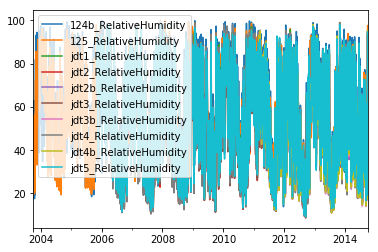

In [17]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 # 
                       
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head()

### 6. WindDirection

In [19]:
siteList = ['124b','125','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b','jdt5']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/weather_data_'+i+'.csv', 
                        header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    if 'w_d' in data.columns:
        data = data[['w_d']] #### need to check which one to use 
        data.columns = [i+'_WindDirection'] 
        data = threC(data,'WindDirection')
        df_lst.append(data)  
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

124b
125
jdt1
jdt2
jdt2b
jdt3
jdt3b
jdt4
jdt4b
jdt5
['jdt2b_WindDirection', datetime.date(2011, 3, 10)]
nan ratio is 0.08333333333333333 , groupby value is 227.55909090909088
['jdt2b_WindDirection', datetime.date(2011, 3, 19)]
nan ratio is 0.041666666666666664 , groupby value is 217.35217391304354
['jdt2b_WindDirection', datetime.date(2011, 4, 7)]
nan ratio is 0.08333333333333333 , groupby value is 230.33636363636367
['jdt2b_WindDirection', datetime.date(2011, 4, 21)]
nan ratio is 0.08333333333333333 , groupby value is 206.80454545454543
['jdt2b_WindDirection', datetime.date(2011, 5, 26)]
nan ratio is 0.041666666666666664 , groupby value is 214.09565217391307
['jdt2b_WindDirection', datetime.date(2011, 6, 21)]
nan ratio is 0.041666666666666664 , groupby value is 213.39130434782604
['jdt2b_WindDirection', datetime.date(2011, 7, 1)]
nan ratio is 0.041666666666666664 , groupby value is 199.00869565217386
['jdt2b_WindDirection', datetime.date(2011, 7, 4)]
nan ratio is 0.041666666666666664 

['jdt3b_WindDirection', datetime.date(2012, 2, 2)]
nan ratio is 0.041666666666666664 , groupby value is 211.2826086956522
['jdt3b_WindDirection', datetime.date(2012, 2, 10)]
nan ratio is 0.041666666666666664 , groupby value is 192.0608695652174
['jdt3b_WindDirection', datetime.date(2012, 3, 18)]
nan ratio is 0.041666666666666664 , groupby value is 161.91304347826085
['jdt3b_WindDirection', datetime.date(2012, 4, 8)]
nan ratio is 0.041666666666666664 , groupby value is 168.16521739130434
['jdt3b_WindDirection', datetime.date(2012, 4, 14)]
nan ratio is 0.08333333333333333 , groupby value is 206.79999999999998
['jdt3b_WindDirection', datetime.date(2012, 5, 4)]
nan ratio is 0.041666666666666664 , groupby value is 241.9826086956522
['jdt3b_WindDirection', datetime.date(2012, 6, 2)]
nan ratio is 0.041666666666666664 , groupby value is 206.57391304347829
['jdt3b_WindDirection', datetime.date(2012, 6, 9)]
nan ratio is 0.08333333333333333 , groupby value is 242.57727272727269
['jdt3b_WindDirect

['jdt4b_WindDirection', datetime.date(2013, 3, 2)]
nan ratio is 0.041666666666666664 , groupby value is 171.28695652173914
['jdt4b_WindDirection', datetime.date(2013, 3, 5)]
nan ratio is 0.041666666666666664 , groupby value is 172.40869565217392
['jdt4b_WindDirection', datetime.date(2013, 3, 7)]
nan ratio is 0.041666666666666664 , groupby value is 209.74347826086958
['jdt4b_WindDirection', datetime.date(2013, 3, 15)]
nan ratio is 0.041666666666666664 , groupby value is 248.6086956521739
['jdt4b_WindDirection', datetime.date(2013, 3, 20)]
nan ratio is 0.08333333333333333 , groupby value is 234.3045454545455
['jdt4b_WindDirection', datetime.date(2013, 3, 31)]
nan ratio is 0.041666666666666664 , groupby value is 162.69999999999996
['jdt4b_WindDirection', datetime.date(2013, 4, 20)]
nan ratio is 0.041666666666666664 , groupby value is 271.60869565217394
['jdt4b_WindDirection', datetime.date(2013, 4, 27)]
nan ratio is 0.041666666666666664 , groupby value is 253.43913043478258
['jdt4b_WindDi

124b_WindDirection 125_WindDirection jdt2b_WindDirection  \
2003-10-01            156.904           156.904                 NaN   
2003-10-02            183.592           183.592                 NaN   

           jdt3_WindDirection jdt3b_WindDirection jdt4b_WindDirection  
2003-10-01                NaN                 NaN                 NaN  
2003-10-02                NaN                 NaN                 NaN

124b_WindDirection 125_WindDirection jdt2b_WindDirection  \
2014-09-30            236.375            264.25             235.454   
2014-10-01                NaN               NaN               249.6   

           jdt3_WindDirection jdt3b_WindDirection jdt4b_WindDirection  
2014-09-30            264.738             231.842             255.254  
2014-10-01              307.2               282.8               271.8

124b_WindDirection
125_WindDirection
jdt2b_WindDirection
jdt3_WindDirection
jdt3b_WindDirection
jdt4b_WindDirection


124b_WindDirection  125_WindDirection  jdt2b_WindDirection  \
2003-10-01          156.904167         156.904167                  NaN   
2003-10-02          183.591667         183.591667                  NaN   
2003-10-03          154.445833         154.445833                  NaN   
2003-10-04          179.416667         179.416667                  NaN   
2003-10-05          157.525000         157.525000                  NaN   

            jdt3_WindDirection  jdt3b_WindDirection  jdt4b_WindDirection  
2003-10-01                 NaN                  NaN                  NaN  
2003-10-02                 NaN                  NaN                  NaN  
2003-10-03                 NaN                  NaN                  NaN  
2003-10-04                 NaN                  NaN                  NaN  
2003-10-05                 NaN                  NaN                  NaN

<Figure size 720x288 with 0 Axes>

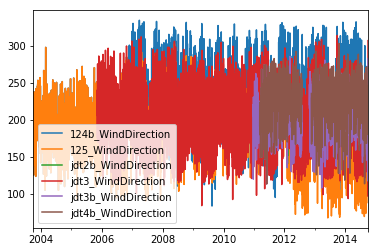

In [20]:
prep = threC(prep,'WindDirection')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head()

### 7. Wind Speed

In [21]:
siteList = ['124b','125','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b','jdt5']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/weather_data_'+i+'.csv', 
                        header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    if 'w_s' in data.columns:
        data = data[['w_s']] #### need to check which one to use 
        data.columns = [i+'_WindSpeed']
        data = threC(data,'WindSpeed')
        df_lst.append(data)  
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

124b
125
jdt1
jdt2
jdt2b
jdt3
jdt3b
jdt4
jdt4b
jdt5
['jdt2b_WindSpeed', datetime.date(2011, 3, 10)]
nan ratio is 0.08333333333333333 , groupby value is 6.927272727272728
['jdt2b_WindSpeed', datetime.date(2011, 4, 21)]
nan ratio is 0.08333333333333333 , groupby value is 2.472727272727272
['jdt2b_WindSpeed', datetime.date(2011, 5, 26)]
nan ratio is 0.041666666666666664 , groupby value is 4.004347826086957
['jdt2b_WindSpeed', datetime.date(2011, 6, 21)]
nan ratio is 0.041666666666666664 , groupby value is 2.3434782608695657
['jdt2b_WindSpeed', datetime.date(2011, 7, 1)]
nan ratio is 0.041666666666666664 , groupby value is 2.156521739130435
['jdt2b_WindSpeed', datetime.date(2011, 7, 4)]
nan ratio is 0.041666666666666664 , groupby value is 2.1695652173913045
['jdt2b_WindSpeed', datetime.date(2011, 7, 9)]
nan ratio is 0.041666666666666664 , groupby value is 2.11304347826087
['jdt2b_WindSpeed', datetime.date(2011, 7, 23)]
nan ratio is 0.041666666666666664 , groupby value is 2.004347826086956


['jdt4b_WindSpeed', datetime.date(2012, 12, 12)]
nan ratio is 0.041666666666666664 , groupby value is 3.243478260869565
['jdt4b_WindSpeed', datetime.date(2012, 12, 17)]
nan ratio is 0.08333333333333333 , groupby value is 6.922727272727272
['jdt4b_WindSpeed', datetime.date(2012, 12, 29)]
nan ratio is 0.08333333333333333 , groupby value is 1.1636363636363638
['jdt4b_WindSpeed', datetime.date(2013, 1, 18)]
nan ratio is 0.041666666666666664 , groupby value is 1.4739130434782608
['jdt4b_WindSpeed', datetime.date(2013, 2, 8)]
nan ratio is 0.041666666666666664 , groupby value is 1.8913043478260874
['jdt4b_WindSpeed', datetime.date(2013, 3, 20)]
nan ratio is 0.08333333333333333 , groupby value is 7.881818181818181
['jdt4b_WindSpeed', datetime.date(2013, 12, 4)]
nan ratio is 0.08333333333333333 , groupby value is 1.3272727272727276
['jdt4b_WindSpeed', datetime.date(2013, 12, 5)]
nan ratio is 0.08333333333333333 , groupby value is 1.3999999999999997
['jdt4b_WindSpeed', datetime.date(2013, 12, 6)

124b_WindSpeed 125_WindSpeed jdt2b_WindSpeed jdt3_WindSpeed  \
2003-10-01        1.19583       1.19583             NaN            NaN   
2003-10-02         1.0375        1.0375             NaN            NaN   

           jdt3b_WindSpeed jdt4b_WindSpeed  
2003-10-01             NaN             NaN  
2003-10-02             NaN             NaN

124b_WindSpeed 125_WindSpeed jdt2b_WindSpeed jdt3_WindSpeed  \
2014-09-30         1.7875        2.5125           3.075        2.83333   
2014-10-01            NaN           NaN             1.7            2.6   

           jdt3b_WindSpeed jdt4b_WindSpeed  
2014-09-30          3.0125         3.19583  
2014-10-01             2.5             1.8

124b_WindSpeed
125_WindSpeed
jdt2b_WindSpeed
jdt3_WindSpeed
jdt3b_WindSpeed
jdt4b_WindSpeed


124b_WindSpeed  125_WindSpeed  jdt2b_WindSpeed  jdt3_WindSpeed  \
2003-10-01        1.195833       1.195833              NaN             NaN   
2003-10-02        1.037500       1.037500              NaN             NaN   
2003-10-03        1.600000       1.600000              NaN             NaN   
2003-10-04        1.087500       1.087500              NaN             NaN   
2003-10-05        0.991667       0.991667              NaN             NaN   

            jdt3b_WindSpeed  jdt4b_WindSpeed  
2003-10-01              NaN              NaN  
2003-10-02              NaN              NaN  
2003-10-03              NaN              NaN  
2003-10-04              NaN              NaN  
2003-10-05              NaN              NaN

<Figure size 720x288 with 0 Axes>

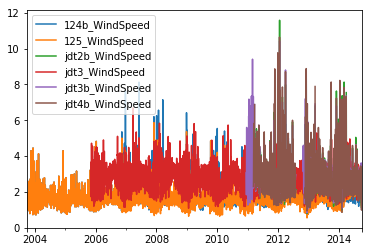

In [22]:
prep = threC(prep,'WindSpeed')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head()

### 8. SWE
### None

### 9. SnowDepth

In [23]:
data = pd.read_csv('https://data.nal.usda.gov/system/files/rc.tg_.dc_.jd_sc.csv', header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
data.drop(columns=[' WY','Year','Month','Day','Hour','Minute'], inplace = True)
data.index = pd.to_datetime(data.index)
data = data.groupby(data.index.date).mean()
display(data.head(2))
data.tail(2)

z_s_124  z_s_124b  z_s_125  z_s_jdt1  z_s_jdt2  z_s_jdt3  \
2003-10-01      0.0   -9999.0      0.0   -9999.0   -9999.0   -9999.0   
2003-10-02      0.0   -9999.0      0.0   -9999.0   -9999.0   -9999.0   

            z_s_jdt4  z_s_jdt5  z_s_jdt2b  z_s_jdt3b  z_s_jdt4b  
2003-10-01   -9999.0   -9999.0    -9999.0    -9999.0    -9999.0  
2003-10-02   -9999.0   -9999.0    -9999.0    -9999.0    -9999.0

z_s_124  z_s_124b  z_s_125  z_s_jdt1  z_s_jdt2  z_s_jdt3  \
2014-09-29      0.0       0.0      0.0       0.0       0.0       0.0   
2014-09-30      0.0       0.0      0.0       0.0       0.0       0.0   

            z_s_jdt4  z_s_jdt5  z_s_jdt2b  z_s_jdt3b  z_s_jdt4b  
2014-09-29       0.0       0.0        0.0        0.0        0.0  
2014-09-30       0.0       0.0        0.0        0.0        0.0

In [24]:
prep = copy.deepcopy(data)
prep = threC(prep,'SnowDepth')
display(prep.head(2))
prep.columns = ['124_SnowDepth','124b_SnowDepth','125_SnowDepth','jdt1_SnowDepth','jdt2_SnowDepth',
                    'jdt3_SnowDepth','jdt4_SnowDepth','jdt5_SnowDepth','jdt2b_SnowDepth','jdt3b_SnowDepth','jdt4b_SnowDepth']

z_s_124  z_s_124b  z_s_125  z_s_jdt1  z_s_jdt2  z_s_jdt3  \
2003-10-01      0.0       NaN      0.0       NaN       NaN       NaN   
2003-10-02      0.0       NaN      0.0       NaN       NaN       NaN   

            z_s_jdt4  z_s_jdt5  z_s_jdt2b  z_s_jdt3b  z_s_jdt4b  
2003-10-01       NaN       NaN        NaN        NaN        NaN  
2003-10-02       NaN       NaN        NaN        NaN        NaN

124_SnowDepth
124b_SnowDepth
125_SnowDepth
jdt1_SnowDepth
jdt2_SnowDepth
jdt3_SnowDepth
jdt4_SnowDepth
jdt5_SnowDepth
jdt2b_SnowDepth
jdt3b_SnowDepth
jdt4b_SnowDepth


124_SnowDepth  124b_SnowDepth  125_SnowDepth  jdt1_SnowDepth  \
2003-10-01            0.0             NaN            0.0             NaN   
2003-10-02            0.0             NaN            0.0             NaN   
2003-10-03            0.0             NaN            0.0             NaN   
2003-10-04            0.0             NaN            0.0             NaN   
2003-10-05            0.0             NaN            0.0             NaN   

            jdt2_SnowDepth  jdt3_SnowDepth  jdt4_SnowDepth  jdt5_SnowDepth  \
2003-10-01             NaN             NaN             NaN             NaN   
2003-10-02             NaN             NaN             NaN             NaN   
2003-10-03             NaN             NaN             NaN             NaN   
2003-10-04             NaN             NaN             NaN             NaN   
2003-10-05             NaN             NaN             NaN             NaN   

            jdt2b_SnowDepth  jdt3b_SnowDepth  jdt4b_SnowDepth  
2003-10-01              NaN              NaN              NaN  
2003-10-02              NaN              NaN              NaN  
2003-10-03              NaN              NaN              NaN  
2003-10-04              NaN              NaN              NaN  
2003-10-05              NaN              NaN              NaN

<Figure size 720x288 with 0 Axes>

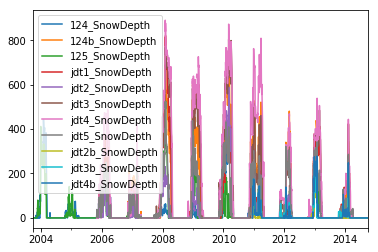

In [25]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10 # 
                       
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
SnowDepth.head()

### 10. VaporPressure

In [26]:
siteList = ['124b','125','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b','jdt5']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/weather_data_'+i+'.csv', 
                        header = 0,index_col = 'Date_time',
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    if 'e_a' in data.columns:
        data = copy.deepcopy(data[['e_a']]/1000)#### need to check which one to use 
        data.columns = [i+'_VaporPressure']
    data = threC(data,'VaporPressure')
    df_lst.append(data)  
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

124b
125
jdt1
jdt2
jdt2b
jdt3
jdt3b
jdt4
jdt4b
jdt5
['jdt1_VaporPressure', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.8622608695652175
['jdt1_VaporPressure', datetime.date(2010, 8, 19)]
nan ratio is 0.041666666666666664 , groupby value is 0.5901304347826087
['jdt1_VaporPressure', datetime.date(2014, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is 0.7304347826086959
['jdt2_VaporPressure', datetime.date(2010, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.8227391304347826
['jdt3_VaporPressure', datetime.date(2010, 6, 26)]
nan ratio is 0.08333333333333333 , groupby value is 0.9418181818181819
['jdt3_VaporPressure', datetime.date(2010, 9, 30)]
nan ratio is 0.08333333333333333 , groupby value is 0.5546818181818183
['jdt4_VaporPressure', datetime.date(2009, 8, 21)]
nan ratio is 0.08333333333333333 , groupby value is 0.8227727272727272
['jdt4_VaporPressure', datetime.date(2009, 9, 3)]
nan ratio is 0.041666666666666664 , grou

124b_VaporPressure 125_VaporPressure jdt1_VaporPressure  \
2003-10-01           0.606708          0.601083                NaN   
2003-10-02            0.77625          0.780292                NaN   

           jdt2_VaporPressure jdt2b_VaporPressure jdt3_VaporPressure  \
2003-10-01                NaN                 NaN                NaN   
2003-10-02                NaN                 NaN                NaN   

           jdt3b_VaporPressure jdt4_VaporPressure jdt4b_VaporPressure  \
2003-10-01                 NaN                NaN                 NaN   
2003-10-02                 NaN                NaN                 NaN   

           jdt5_VaporPressure  
2003-10-01                NaN  
2003-10-02                NaN

124b_VaporPressure 125_VaporPressure jdt1_VaporPressure  \
2014-09-30           0.761542             0.794           0.798708   
2014-10-01                NaN               NaN              0.637   

           jdt2_VaporPressure jdt2b_VaporPressure jdt3_VaporPressure  \
2014-09-30           0.739042            0.763083           0.746708   
2014-10-01              0.598               0.606              0.598   

           jdt3b_VaporPressure jdt4_VaporPressure jdt4b_VaporPressure  \
2014-09-30            0.765458           0.756083            0.742333   
2014-10-01               0.605              0.607               0.588   

           jdt5_VaporPressure  
2014-09-30           0.761958  
2014-10-01              0.608

124b_VaporPressure
125_VaporPressure
jdt1_VaporPressure
jdt2_VaporPressure
jdt2b_VaporPressure
jdt3_VaporPressure
jdt3b_VaporPressure
jdt4_VaporPressure
jdt4b_VaporPressure
jdt5_VaporPressure


124b_VaporPressure  125_VaporPressure  jdt1_VaporPressure  \
2003-10-01            0.606708           0.601083                 NaN   
2003-10-02            0.776250           0.780292                 NaN   
2003-10-03            0.918250           0.902625                 NaN   
2003-10-04            0.880000           0.875500                 NaN   
2003-10-05            0.805583           0.810875                 NaN   

            jdt2_VaporPressure  jdt2b_VaporPressure  jdt3_VaporPressure  \
2003-10-01                 NaN                  NaN                 NaN   
2003-10-02                 NaN                  NaN                 NaN   
2003-10-03                 NaN                  NaN                 NaN   
2003-10-04                 NaN                  NaN                 NaN   
2003-10-05                 NaN                  NaN                 NaN   

            jdt3b_VaporPressure  jdt4_VaporPressure  jdt4b_VaporPressure  \
2003-10-01                  NaN                 NaN                  NaN   
2003-10-02                  NaN                 NaN                  NaN   
2003-10-03                  NaN                 NaN                  NaN   
2003-10-04                  NaN                 NaN                  NaN   
2003-10-05                  NaN                 NaN                  NaN   

            jdt5_VaporPressure  
2003-10-01                 NaN  
2003-10-02                 NaN  
2003-10-03                 NaN  
2003-10-04                 NaN  
2003-10-05                 NaN

<Figure size 720x288 with 0 Axes>

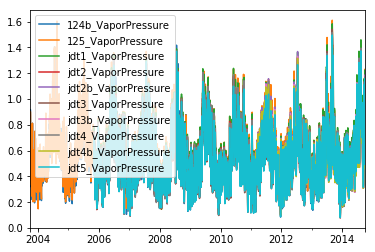

In [27]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
VaporPressure= copy.deepcopy(df)
VaporPressure.plot()
VaporPressure.head()

### 11. SoilMoisture

In [28]:
siteList = ['124ba','124bs','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/rc.tg_.dc_.jd-'+ i +'_stm_0.csv', 
                       header = 0,index_col = 'Date_time',  
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    display(data.head(2))
    wanted_col=[]
    for c in data.columns:
        if 's_m' in c:
            wanted_col.append(c)
    data=data[wanted_col]
    data.columns=[str(i) +'_SoilMoisture_'+ k.split('_')[-1] for k in data.columns]
    data = threC(data,'SoilMoisture')
    display(data.head(2))
    df_lst.append(data)  

124ba


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_50  T_g_75  T_g_90   s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                     
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   

                     s_m_90  
Date_time                    
2010-10-01 00:00:00 -9999.0  
2010-10-01 01:00:00 -9999.0

124ba_SoilMoisture_5  124ba_SoilMoisture_20  \
Date_time                                                          
2010-10-01 00:00:00                   NaN                    NaN   
2010-10-01 01:00:00                   NaN                    NaN   

                     124ba_SoilMoisture_50  124ba_SoilMoisture_75  \
Date_time                                                           
2010-10-01 00:00:00                    NaN                    NaN   
2010-10-01 01:00:00                    NaN                    NaN   

                     124ba_SoilMoisture_90  
Date_time                                   
2010-10-01 00:00:00                    NaN  
2010-10-01 01:00:00                    NaN

124bs


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                            
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

124bs_SoilMoisture_5  124bs_SoilMoisture_20  \
Date_time                                                          
2010-10-01 00:00:00                   NaN                    NaN   
2010-10-01 01:00:00                   NaN                    NaN   

                     124bs_SoilMoisture_35  124bs_SoilMoisture_50  
Date_time                                                          
2010-10-01 00:00:00                    NaN                    NaN  
2010-10-01 01:00:00                    NaN                    NaN

jdt1


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   12.7    14.7   
2010-10-01 01:00:00  2011  2010     10    1     1       0   12.4    14.6   

                     T_g_50  T_g_90  T_g_130  T_g_190  s_m_5  s_m_20  s_m_50  \
Date_time                                                                      
2010-10-01 00:00:00    13.4    13.1     12.4     12.0  0.092   0.041   0.066   
2010-10-01 01:00:00    13.5    13.1     12.4     12.0  0.090   0.039   0.064   

                     s_m_90  s_m_130  s_m_190  
Date_time                                      
2010-10-01 00:00:00   0.112    0.108    0.148  
2010-10-01 01:00:00   0.110    0.108    0.140

jdt1_SoilMoisture_5  jdt1_SoilMoisture_20  \
Date_time                                                        
2010-10-01 00:00:00                0.092                 0.041   
2010-10-01 01:00:00                0.090                 0.039   

                     jdt1_SoilMoisture_50  jdt1_SoilMoisture_90  \
Date_time                                                         
2010-10-01 00:00:00                 0.066                 0.112   
2010-10-01 01:00:00                 0.064                 0.110   

                     jdt1_SoilMoisture_130  jdt1_SoilMoisture_190  
Date_time                                                          
2010-10-01 00:00:00                  0.108                  0.148  
2010-10-01 01:00:00                  0.108                  0.140

jdt2


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   11.5    12.6   
2010-10-01 01:00:00  2011  2010     10    1     1       0   11.3    12.7   

                     T_g_50  T_g_75  T_g_100    s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                       
2010-10-01 00:00:00    12.7    12.8     12.4  0.03625   0.041   0.036   0.021   
2010-10-01 01:00:00    12.7    12.7     12.4  0.03725   0.047   0.042   0.027   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00  0.00418  
2010-10-01 01:00:00  0.00297

jdt2_SoilMoisture_5  jdt2_SoilMoisture_20  \
Date_time                                                        
2010-10-01 00:00:00              0.03625                 0.041   
2010-10-01 01:00:00              0.03725                 0.047   

                     jdt2_SoilMoisture_50  jdt2_SoilMoisture_75  \
Date_time                                                         
2010-10-01 00:00:00                 0.036                 0.021   
2010-10-01 01:00:00                 0.042                 0.027   

                     jdt2_SoilMoisture_100  
Date_time                                   
2010-10-01 00:00:00                0.00418  
2010-10-01 01:00:00                0.00297

jdt2b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50  T_g_75   s_m_5  s_m_20  s_m_35  s_m_50  \
Date_time                                                                     
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   

                     s_m_75  
Date_time                    
2010-10-01 00:00:00 -9999.0  
2010-10-01 01:00:00 -9999.0

jdt2b_SoilMoisture_5  jdt2b_SoilMoisture_20  \
Date_time                                                          
2010-10-01 00:00:00                   NaN                    NaN   
2010-10-01 01:00:00                   NaN                    NaN   

                     jdt2b_SoilMoisture_35  jdt2b_SoilMoisture_50  \
Date_time                                                           
2010-10-01 00:00:00                    NaN                    NaN   
2010-10-01 01:00:00                    NaN                    NaN   

                     jdt2b_SoilMoisture_75  
Date_time                                   
2010-10-01 00:00:00                    NaN  
2010-10-01 01:00:00                    NaN

jdt3


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   11.3    12.4   
2010-10-01 01:00:00  2011  2010     10    1     1       0   11.1    12.3   

                     T_g_50  T_g_75  T_g_100  s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                     
2010-10-01 00:00:00    11.7    11.2     11.5  0.043   0.063   0.083   0.073   
2010-10-01 01:00:00    11.7    11.2     11.3  0.039   0.059   0.079   0.069   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00    0.078  
2010-10-01 01:00:00    0.074

jdt3_SoilMoisture_5  jdt3_SoilMoisture_20  \
Date_time                                                        
2010-10-01 00:00:00                0.043                 0.063   
2010-10-01 01:00:00                0.039                 0.059   

                     jdt3_SoilMoisture_50  jdt3_SoilMoisture_75  \
Date_time                                                         
2010-10-01 00:00:00                 0.083                 0.073   
2010-10-01 01:00:00                 0.079                 0.069   

                     jdt3_SoilMoisture_100  
Date_time                                   
2010-10-01 00:00:00                  0.078  
2010-10-01 01:00:00                  0.074

jdt3b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                            
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

jdt3b_SoilMoisture_5  jdt3b_SoilMoisture_20  \
Date_time                                                          
2010-10-01 00:00:00                   NaN                    NaN   
2010-10-01 01:00:00                   NaN                    NaN   

                     jdt3b_SoilMoisture_35  jdt3b_SoilMoisture_50  
Date_time                                                          
2010-10-01 00:00:00                    NaN                    NaN  
2010-10-01 01:00:00                    NaN                    NaN

jdt4


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   10.8    12.1   
2010-10-01 01:00:00  2011  2010     10    1     1       0   10.6    12.0   

                     T_g_50  T_g_75  T_g_100   s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                      
2010-10-01 00:00:00    11.0    11.1     10.7  0.0305   0.036   0.016   0.017   
2010-10-01 01:00:00    11.2    11.0     10.8  0.0315   0.031   0.019   0.017   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00    0.021  
2010-10-01 01:00:00    0.021

jdt4_SoilMoisture_5  jdt4_SoilMoisture_20  \
Date_time                                                        
2010-10-01 00:00:00               0.0305                 0.036   
2010-10-01 01:00:00               0.0315                 0.031   

                     jdt4_SoilMoisture_50  jdt4_SoilMoisture_75  \
Date_time                                                         
2010-10-01 00:00:00                 0.016                 0.017   
2010-10-01 01:00:00                 0.019                 0.017   

                     jdt4_SoilMoisture_100  
Date_time                                   
2010-10-01 00:00:00                  0.021  
2010-10-01 01:00:00                  0.021

jdt4b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_035  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                             
2010-10-01 00:00:00  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

jdt4b_SoilMoisture_5  jdt4b_SoilMoisture_20  \
Date_time                                                          
2010-10-01 00:00:00                   NaN                    NaN   
2010-10-01 01:00:00                   NaN                    NaN   

                     jdt4b_SoilMoisture_35  jdt4b_SoilMoisture_50  
Date_time                                                          
2010-10-01 00:00:00                    NaN                    NaN  
2010-10-01 01:00:00                    NaN                    NaN

In [29]:
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

['jdt2_SoilMoisture_100', datetime.date(2010, 10, 2)]
nan ratio is 0.08333333333333333 , groupby value is 0.0018428945454545453
The final table is:


124ba_SoilMoisture_5 124ba_SoilMoisture_20 124ba_SoilMoisture_50  \
2010-10-01                  NaN                   NaN                   NaN   
2010-10-02                  NaN                   NaN                   NaN   

           124ba_SoilMoisture_75 124ba_SoilMoisture_90 124bs_SoilMoisture_5  \
2010-10-01                   NaN                   NaN                  NaN   
2010-10-02                   NaN                   NaN                  NaN   

           124bs_SoilMoisture_20 124bs_SoilMoisture_35 124bs_SoilMoisture_50  \
2010-10-01                   NaN                   NaN                   NaN   
2010-10-02                   NaN                   NaN                   NaN   

           jdt1_SoilMoisture_5  ... jdt3b_SoilMoisture_50 jdt4_SoilMoisture_5  \
2010-10-01            0.091125  ...                   NaN           0.0300417   
2010-10-02           0.0817083  ...                   NaN           0.0296042   

           jdt4_SoilMoisture_20 jdt4_SoilMoisture_50 jdt4_SoilMoisture_75  \
2010-10-01            0.0328333              0.01925                0.019   
2010-10-02             0.032125              0.01825            0.0203333   

           jdt4_SoilMoisture_100 jdt4b_SoilMoisture_5 jdt4b_SoilMoisture_20  \
2010-10-01              0.020875                  NaN                   NaN   
2010-10-02                 0.021                  NaN                   NaN   

           jdt4b_SoilMoisture_35 jdt4b_SoilMoisture_50  
2010-10-01                   NaN                   NaN  
2010-10-02                   NaN                   NaN  

[2 rows x 43 columns]

124ba_SoilMoisture_5 124ba_SoilMoisture_20 124ba_SoilMoisture_50  \
2014-09-29             0.114875              0.117875              0.151625   
2014-09-30             0.152542              0.190667                0.1525   

           124ba_SoilMoisture_75 124ba_SoilMoisture_90 124bs_SoilMoisture_5  \
2014-09-29              0.256875               0.16075             0.347333   
2014-09-30              0.258417               0.16125             0.286083   

           124bs_SoilMoisture_20 124bs_SoilMoisture_35 124bs_SoilMoisture_50  \
2014-09-29              0.176917             0.0976667              0.114208   
2014-09-30              0.229125             0.0967083              0.114125   

           jdt1_SoilMoisture_5  ... jdt3b_SoilMoisture_50 jdt4_SoilMoisture_5  \
2014-09-29            0.201167  ...             0.0869167                 NaN   
2014-09-30            0.203958  ...             0.0849583                 NaN   

           jdt4_SoilMoisture_20 jdt4_SoilMoisture_50 jdt4_SoilMoisture_75  \
2014-09-29                  NaN                  NaN                  NaN   
2014-09-30                  NaN                  NaN                  NaN   

           jdt4_SoilMoisture_100 jdt4b_SoilMoisture_5 jdt4b_SoilMoisture_20  \
2014-09-29                   NaN              0.19965              0.172167   
2014-09-30                   NaN             0.178433              0.195708   

           jdt4b_SoilMoisture_35 jdt4b_SoilMoisture_50  
2014-09-29              0.157392                 0.082  
2014-09-30              0.221083              0.082175  

[2 rows x 43 columns]

124ba_SoilMoisture_5
124ba_SoilMoisture_20
124ba_SoilMoisture_50
124ba_SoilMoisture_75
124ba_SoilMoisture_90
124bs_SoilMoisture_5
124bs_SoilMoisture_20
124bs_SoilMoisture_35
124bs_SoilMoisture_50
jdt1_SoilMoisture_5
jdt1_SoilMoisture_20
jdt1_SoilMoisture_50
jdt1_SoilMoisture_90
jdt1_SoilMoisture_130
jdt1_SoilMoisture_190
jdt2_SoilMoisture_5
jdt2_SoilMoisture_20
jdt2_SoilMoisture_50
jdt2_SoilMoisture_75
jdt2_SoilMoisture_100
jdt2b_SoilMoisture_5
jdt2b_SoilMoisture_20
jdt2b_SoilMoisture_35
jdt2b_SoilMoisture_50
jdt2b_SoilMoisture_75
jdt3_SoilMoisture_5
jdt3_SoilMoisture_20
jdt3_SoilMoisture_50
jdt3_SoilMoisture_75
jdt3_SoilMoisture_100
jdt3b_SoilMoisture_5
jdt3b_SoilMoisture_20
jdt3b_SoilMoisture_35
jdt3b_SoilMoisture_50
jdt4_SoilMoisture_5
jdt4_SoilMoisture_20
jdt4_SoilMoisture_50
jdt4_SoilMoisture_75
jdt4_SoilMoisture_100
jdt4b_SoilMoisture_5
jdt4b_SoilMoisture_20
jdt4b_SoilMoisture_35
jdt4b_SoilMoisture_50


124ba_SoilMoisture_5  124ba_SoilMoisture_20  \
2010-10-01                   NaN                    NaN   
2010-10-02                   NaN                    NaN   
2010-10-03                   NaN                    NaN   
2010-10-04                   NaN                    NaN   
2010-10-05                   NaN                    NaN   

            124ba_SoilMoisture_50  124ba_SoilMoisture_75  \
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   
2010-10-03                    NaN                    NaN   
2010-10-04                    NaN                    NaN   
2010-10-05                    NaN                    NaN   

            124ba_SoilMoisture_90  124bs_SoilMoisture_5  \
2010-10-01                    NaN                   NaN   
2010-10-02                    NaN                   NaN   
2010-10-03                    NaN                   NaN   
2010-10-04                    NaN                   NaN   
2010-10-05                    NaN                   NaN   

            124bs_SoilMoisture_20  124bs_SoilMoisture_35  \
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   
2010-10-03                    NaN                    NaN   
2010-10-04                    NaN                    NaN   
2010-10-05                    NaN                    NaN   

            124bs_SoilMoisture_50  jdt1_SoilMoisture_5  ...  \
2010-10-01                    NaN             9.112500  ...   
2010-10-02                    NaN             8.170833  ...   
2010-10-03                    NaN             8.112500  ...   
2010-10-04                    NaN            13.308333  ...   
2010-10-05                    NaN            22.091667  ...   

            jdt3b_SoilMoisture_50  jdt4_SoilMoisture_5  jdt4_SoilMoisture_20  \
2010-10-01                    NaN             3.004167              3.283333   
2010-10-02                    NaN             2.960417              3.212500   
2010-10-03                    NaN             2.825000              3.241667   
2010-10-04                    NaN             3.456250              3.091667   
2010-10-05                    NaN             6.195833              3.145833   

            jdt4_SoilMoisture_50  jdt4_SoilMoisture_75  jdt4_SoilMoisture_100  \
2010-10-01              1.925000              1.900000               2.087500   
2010-10-02              1.825000              2.033333               2.100000   
2010-10-03              1.900000              2.075000               2.075000   
2010-10-04              2.033333              2.287500               1.958333   
2010-10-05              2.125000              2.225000               1.750000   

            jdt4b_SoilMoisture_5  jdt4b_SoilMoisture_20  \
2010-10-01                   NaN                    NaN   
2010-10-02                   NaN                    NaN   
2010-10-03                   NaN                    NaN   
2010-10-04                   NaN                    NaN   
2010-10-05                   NaN                    NaN   

            jdt4b_SoilMoisture_35  jdt4b_SoilMoisture_50  
2010-10-01                    NaN                    NaN  
2010-10-02                    NaN                    NaN  
2010-10-03                    NaN                    NaN  
2010-10-04                    NaN                    NaN  
2010-10-05                    NaN                    NaN  

[5 rows x 43 columns]

<Figure size 720x288 with 0 Axes>

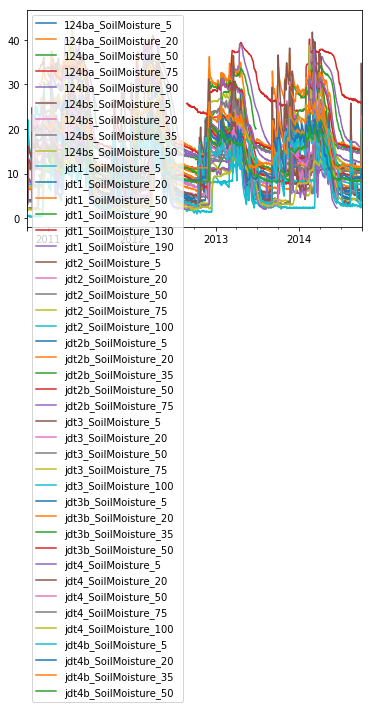

In [30]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 # 
        
df = threC(df, 'SoilMoisture')
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
SoilMoisture.head()

### 12. SoilTemperature

In [31]:
siteList = ['124ba','124bs','jdt1','jdt2','jdt2b','jdt3','jdt3b','jdt4','jdt4b']
df_lst=[]
for i in siteList:
    print(i)
    data = pd.read_csv('https://data.nal.usda.gov/system/files/rc.tg_.dc_.jd-'+ i +'_stm_0.csv', 
                       header = 0,index_col = 'Date_time',  
                     parse_dates = True, infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    display(data.head(2))
    wanted_col=[]
    for c in data.columns:
        if 'T_g' in c:
            wanted_col.append(c)
    data=data[wanted_col]
    data.columns=[str(i) +'_SoilTemperature_'+ k.split('_')[-1] for k in data.columns]
    data = threC(data,'SoilTemperature')
    display(data.head(2))
    df_lst.append(data)  

124ba


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_50  T_g_75  T_g_90   s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                     
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   

                     s_m_90  
Date_time                    
2010-10-01 00:00:00 -9999.0  
2010-10-01 01:00:00 -9999.0

124ba_SoilTemperature_5  124ba_SoilTemperature_20  \
Date_time                                                                
2010-10-01 00:00:00                      NaN                       NaN   
2010-10-01 01:00:00                      NaN                       NaN   

                     124ba_SoilTemperature_50  124ba_SoilTemperature_75  \
Date_time                                                                 
2010-10-01 00:00:00                       NaN                       NaN   
2010-10-01 01:00:00                       NaN                       NaN   

                     124ba_SoilTemperature_90  
Date_time                                      
2010-10-01 00:00:00                       NaN  
2010-10-01 01:00:00                       NaN

124bs


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                            
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

124bs_SoilTemperature_5  124bs_SoilTemperature_20  \
Date_time                                                                
2010-10-01 00:00:00                      NaN                       NaN   
2010-10-01 01:00:00                      NaN                       NaN   

                     124bs_SoilTemperature_35  124bs_SoilTemperature_50  
Date_time                                                                
2010-10-01 00:00:00                       NaN                       NaN  
2010-10-01 01:00:00                       NaN                       NaN

jdt1


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   12.7    14.7   
2010-10-01 01:00:00  2011  2010     10    1     1       0   12.4    14.6   

                     T_g_50  T_g_90  T_g_130  T_g_190  s_m_5  s_m_20  s_m_50  \
Date_time                                                                      
2010-10-01 00:00:00    13.4    13.1     12.4     12.0  0.092   0.041   0.066   
2010-10-01 01:00:00    13.5    13.1     12.4     12.0  0.090   0.039   0.064   

                     s_m_90  s_m_130  s_m_190  
Date_time                                      
2010-10-01 00:00:00   0.112    0.108    0.148  
2010-10-01 01:00:00   0.110    0.108    0.140

jdt1_SoilTemperature_5  jdt1_SoilTemperature_20  \
Date_time                                                              
2010-10-01 00:00:00                    12.7                     14.7   
2010-10-01 01:00:00                    12.4                     14.6   

                     jdt1_SoilTemperature_50  jdt1_SoilTemperature_90  \
Date_time                                                               
2010-10-01 00:00:00                     13.4                     13.1   
2010-10-01 01:00:00                     13.5                     13.1   

                     jdt1_SoilTemperature_130  jdt1_SoilTemperature_190  
Date_time                                                                
2010-10-01 00:00:00                      12.4                      12.0  
2010-10-01 01:00:00                      12.4                      12.0

jdt2


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   11.5    12.6   
2010-10-01 01:00:00  2011  2010     10    1     1       0   11.3    12.7   

                     T_g_50  T_g_75  T_g_100    s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                       
2010-10-01 00:00:00    12.7    12.8     12.4  0.03625   0.041   0.036   0.021   
2010-10-01 01:00:00    12.7    12.7     12.4  0.03725   0.047   0.042   0.027   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00  0.00418  
2010-10-01 01:00:00  0.00297

jdt2_SoilTemperature_5  jdt2_SoilTemperature_20  \
Date_time                                                              
2010-10-01 00:00:00                    11.5                     12.6   
2010-10-01 01:00:00                    11.3                     12.7   

                     jdt2_SoilTemperature_50  jdt2_SoilTemperature_75  \
Date_time                                                               
2010-10-01 00:00:00                     12.7                     12.8   
2010-10-01 01:00:00                     12.7                     12.7   

                     jdt2_SoilTemperature_100  
Date_time                                      
2010-10-01 00:00:00                      12.4  
2010-10-01 01:00:00                      12.4

jdt2b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50  T_g_75   s_m_5  s_m_20  s_m_35  s_m_50  \
Date_time                                                                     
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0   

                     s_m_75  
Date_time                    
2010-10-01 00:00:00 -9999.0  
2010-10-01 01:00:00 -9999.0

jdt2b_SoilTemperature_5  jdt2b_SoilTemperature_20  \
Date_time                                                                
2010-10-01 00:00:00                      NaN                       NaN   
2010-10-01 01:00:00                      NaN                       NaN   

                     jdt2b_SoilTemperature_35  jdt2b_SoilTemperature_50  \
Date_time                                                                 
2010-10-01 00:00:00                       NaN                       NaN   
2010-10-01 01:00:00                       NaN                       NaN   

                     jdt2b_SoilTemperature_75  
Date_time                                      
2010-10-01 00:00:00                       NaN  
2010-10-01 01:00:00                       NaN

jdt3


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   11.3    12.4   
2010-10-01 01:00:00  2011  2010     10    1     1       0   11.1    12.3   

                     T_g_50  T_g_75  T_g_100  s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                     
2010-10-01 00:00:00    11.7    11.2     11.5  0.043   0.063   0.083   0.073   
2010-10-01 01:00:00    11.7    11.2     11.3  0.039   0.059   0.079   0.069   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00    0.078  
2010-10-01 01:00:00    0.074

jdt3_SoilTemperature_5  jdt3_SoilTemperature_20  \
Date_time                                                              
2010-10-01 00:00:00                    11.3                     12.4   
2010-10-01 01:00:00                    11.1                     12.3   

                     jdt3_SoilTemperature_50  jdt3_SoilTemperature_75  \
Date_time                                                               
2010-10-01 00:00:00                     11.7                     11.2   
2010-10-01 01:00:00                     11.7                     11.2   

                     jdt3_SoilTemperature_100  
Date_time                                      
2010-10-01 00:00:00                      11.5  
2010-10-01 01:00:00                      11.3

jdt3b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_35  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                            
2010-10-01 00:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

jdt3b_SoilTemperature_5  jdt3b_SoilTemperature_20  \
Date_time                                                                
2010-10-01 00:00:00                      NaN                       NaN   
2010-10-01 01:00:00                      NaN                       NaN   

                     jdt3b_SoilTemperature_35  jdt3b_SoilTemperature_50  
Date_time                                                                
2010-10-01 00:00:00                       NaN                       NaN  
2010-10-01 01:00:00                       NaN                       NaN

jdt4


WY  Year  Month  Day  Hour  Minute  T_g_5  T_g_20  \
Date_time                                                                  
2010-10-01 00:00:00  2011  2010     10    1     0       0   10.8    12.1   
2010-10-01 01:00:00  2011  2010     10    1     1       0   10.6    12.0   

                     T_g_50  T_g_75  T_g_100   s_m_5  s_m_20  s_m_50  s_m_75  \
Date_time                                                                      
2010-10-01 00:00:00    11.0    11.1     10.7  0.0305   0.036   0.016   0.017   
2010-10-01 01:00:00    11.2    11.0     10.8  0.0315   0.031   0.019   0.017   

                     s_m_100  
Date_time                     
2010-10-01 00:00:00    0.021  
2010-10-01 01:00:00    0.021

jdt4_SoilTemperature_5  jdt4_SoilTemperature_20  \
Date_time                                                              
2010-10-01 00:00:00                    10.8                     12.1   
2010-10-01 01:00:00                    10.6                     12.0   

                     jdt4_SoilTemperature_50  jdt4_SoilTemperature_75  \
Date_time                                                               
2010-10-01 00:00:00                     11.0                     11.1   
2010-10-01 01:00:00                     11.2                     11.0   

                     jdt4_SoilTemperature_100  
Date_time                                      
2010-10-01 00:00:00                      10.7  
2010-10-01 01:00:00                      10.8

jdt4b


WY  Year  Month  Day  Hour  Minute   T_g_5  T_g_20  \
Date_time                                                                   
2010-10-01 00:00:00  2011  2010     10    1     0       0 -9999.0 -9999.0   
2010-10-01 01:00:00  2011  2010     10    1     1       0 -9999.0 -9999.0   

                     T_g_035  T_g_50   s_m_5  s_m_20  s_m_35  s_m_50  
Date_time                                                             
2010-10-01 00:00:00  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0  
2010-10-01 01:00:00  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0

jdt4b_SoilTemperature_5  jdt4b_SoilTemperature_20  \
Date_time                                                                
2010-10-01 00:00:00                      NaN                       NaN   
2010-10-01 01:00:00                      NaN                       NaN   

                     jdt4b_SoilTemperature_035  jdt4b_SoilTemperature_50  
Date_time                                                                 
2010-10-01 00:00:00                        NaN                       NaN  
2010-10-01 01:00:00                        NaN                       NaN

In [32]:
prep=aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

['124ba_SoilTemperature_5', datetime.date(2014, 4, 16)]
nan ratio is 0.08333333333333333 , groupby value is 6.106818181818181
['124ba_SoilTemperature_5', datetime.date(2014, 8, 23)]
nan ratio is 0.08333333333333333 , groupby value is 15.136363636363633
['124ba_SoilTemperature_20', datetime.date(2014, 3, 9)]
nan ratio is 0.041666666666666664 , groupby value is 0.4913043478260869
['124ba_SoilTemperature_20', datetime.date(2014, 3, 11)]
nan ratio is 0.041666666666666664 , groupby value is 0.9130434782608697
['124ba_SoilTemperature_20', datetime.date(2014, 3, 18)]
nan ratio is 0.08333333333333333 , groupby value is 2.286363636363637
['124ba_SoilTemperature_20', datetime.date(2014, 4, 16)]
nan ratio is 0.08333333333333333 , groupby value is 5.861363636363635
['124ba_SoilTemperature_20', datetime.date(2014, 4, 20)]
nan ratio is 0.08333333333333333 , groupby value is 7.068181818181819
['124ba_SoilTemperature_20', datetime.date(2014, 8, 23)]
nan ratio is 0.041666666666666664 , groupby value is

124ba_SoilTemperature_5 124ba_SoilTemperature_20  \
2010-10-01                     NaN                      NaN   
2010-10-02                     NaN                      NaN   

           124ba_SoilTemperature_50 124ba_SoilTemperature_75  \
2010-10-01                      NaN                      NaN   
2010-10-02                      NaN                      NaN   

           124ba_SoilTemperature_90 124bs_SoilTemperature_5  \
2010-10-01                      NaN                     NaN   
2010-10-02                      NaN                     NaN   

           124bs_SoilTemperature_20 124bs_SoilTemperature_35  \
2010-10-01                      NaN                      NaN   
2010-10-02                      NaN                      NaN   

           124bs_SoilTemperature_50 jdt1_SoilTemperature_5  ...  \
2010-10-01                      NaN                 15.125  ...   
2010-10-02                      NaN                15.5625  ...   

           jdt3b_SoilTemperature_50 jdt4_SoilTemperature_5  \
2010-10-01                      NaN                11.8625   
2010-10-02                      NaN                12.2417   

           jdt4_SoilTemperature_20 jdt4_SoilTemperature_50  \
2010-10-01                 11.8375                 11.0875   
2010-10-02                 12.0167                 11.1667   

           jdt4_SoilTemperature_75 jdt4_SoilTemperature_100  \
2010-10-01                 11.0833                  10.7708   
2010-10-02                 11.1083                   10.775   

           jdt4b_SoilTemperature_5 jdt4b_SoilTemperature_20  \
2010-10-01                     NaN                      NaN   
2010-10-02                     NaN                      NaN   

           jdt4b_SoilTemperature_035 jdt4b_SoilTemperature_50  
2010-10-01                       NaN                      NaN  
2010-10-02                       NaN                      NaN  

[2 rows x 43 columns]

124ba_SoilTemperature_5 124ba_SoilTemperature_20  \
2014-09-29                    11.2                   12.275   
2014-09-30                 11.0708                  11.7542   

           124ba_SoilTemperature_50 124ba_SoilTemperature_75  \
2014-09-29                  12.8092                  12.8025   
2014-09-30                  12.5229                   12.635   

           124ba_SoilTemperature_90 124bs_SoilTemperature_5  \
2014-09-29                  12.5679                 11.2667   
2014-09-30                  12.4875                 11.3625   

           124bs_SoilTemperature_20 124bs_SoilTemperature_35  \
2014-09-29                  13.2208                  14.2458   
2014-09-30                  12.4917                  13.4292   

           124bs_SoilTemperature_50 jdt1_SoilTemperature_5  ...  \
2014-09-29                  14.7458                12.8042  ...   
2014-09-30                  14.0458                     12  ...   

           jdt3b_SoilTemperature_50 jdt4_SoilTemperature_5  \
2014-09-29                  18.6375                    NaN   
2014-09-30                  17.5125                    NaN   

           jdt4_SoilTemperature_20 jdt4_SoilTemperature_50  \
2014-09-29                     NaN                     NaN   
2014-09-30                     NaN                     NaN   

           jdt4_SoilTemperature_75 jdt4_SoilTemperature_100  \
2014-09-29                     NaN                      NaN   
2014-09-30                     NaN                      NaN   

           jdt4b_SoilTemperature_5 jdt4b_SoilTemperature_20  \
2014-09-29                  13.925                  16.1708   
2014-09-30                 14.2292                  15.4875   

           jdt4b_SoilTemperature_035 jdt4b_SoilTemperature_50  
2014-09-29                   17.6542                  18.6917  
2014-09-30                   16.3708                  17.5833  

[2 rows x 43 columns]

124ba_SoilTemperature_5
124ba_SoilTemperature_20
124ba_SoilTemperature_50
124ba_SoilTemperature_75
124ba_SoilTemperature_90
124bs_SoilTemperature_5
124bs_SoilTemperature_20
124bs_SoilTemperature_35
124bs_SoilTemperature_50
jdt1_SoilTemperature_5
jdt1_SoilTemperature_20
jdt1_SoilTemperature_50
jdt1_SoilTemperature_90
jdt1_SoilTemperature_130
jdt1_SoilTemperature_190
jdt2_SoilTemperature_5
jdt2_SoilTemperature_20
jdt2_SoilTemperature_50
jdt2_SoilTemperature_75
jdt2_SoilTemperature_100
jdt2b_SoilTemperature_5
jdt2b_SoilTemperature_20
jdt2b_SoilTemperature_35
jdt2b_SoilTemperature_50
jdt2b_SoilTemperature_75
jdt3_SoilTemperature_5
jdt3_SoilTemperature_20
jdt3_SoilTemperature_50
jdt3_SoilTemperature_75
jdt3_SoilTemperature_100
jdt3b_SoilTemperature_5
jdt3b_SoilTemperature_20
jdt3b_SoilTemperature_35
jdt3b_SoilTemperature_50
jdt4_SoilTemperature_5
jdt4_SoilTemperature_20
jdt4_SoilTemperature_50
jdt4_SoilTemperature_75
jdt4_SoilTemperature_100
jdt4b_SoilTemperature_5
jdt4b_SoilTemperature_20


124ba_SoilTemperature_5  124ba_SoilTemperature_20  \
2010-10-01                      NaN                       NaN   
2010-10-02                      NaN                       NaN   
2010-10-03                      NaN                       NaN   
2010-10-04                      NaN                       NaN   
2010-10-05                      NaN                       NaN   

            124ba_SoilTemperature_50  124ba_SoilTemperature_75  \
2010-10-01                       NaN                       NaN   
2010-10-02                       NaN                       NaN   
2010-10-03                       NaN                       NaN   
2010-10-04                       NaN                       NaN   
2010-10-05                       NaN                       NaN   

            124ba_SoilTemperature_90  124bs_SoilTemperature_5  \
2010-10-01                       NaN                      NaN   
2010-10-02                       NaN                      NaN   
2010-10-03                       NaN                      NaN   
2010-10-04                       NaN                      NaN   
2010-10-05                       NaN                      NaN   

            124bs_SoilTemperature_20  124bs_SoilTemperature_35  \
2010-10-01                       NaN                       NaN   
2010-10-02                       NaN                       NaN   
2010-10-03                       NaN                       NaN   
2010-10-04                       NaN                       NaN   
2010-10-05                       NaN                       NaN   

            124bs_SoilTemperature_50  jdt1_SoilTemperature_5  ...  \
2010-10-01                       NaN               15.125000  ...   
2010-10-02                       NaN               15.562500  ...   
2010-10-03                       NaN               16.358333  ...   
2010-10-04                       NaN               13.458333  ...   
2010-10-05                       NaN               11.150000  ...   

            jdt3b_SoilTemperature_50  jdt4_SoilTemperature_5  \
2010-10-01                       NaN               11.862500   
2010-10-02                       NaN               12.241667   
2010-10-03                       NaN               14.041667   
2010-10-04                       NaN               11.666667   
2010-10-05                       NaN                9.762500   

            jdt4_SoilTemperature_20  jdt4_SoilTemperature_50  \
2010-10-01                11.837500                11.087500   
2010-10-02                12.016667                11.166667   
2010-10-03                12.733333                11.250000   
2010-10-04                12.670833                11.433333   
2010-10-05                11.612500                11.416667   

            jdt4_SoilTemperature_75  jdt4_SoilTemperature_100  \
2010-10-01                11.083333                 10.770833   
2010-10-02                11.108333                 10.775000   
2010-10-03                11.162500                 10.775000   
2010-10-04                11.195833                 10.775000   
2010-10-05                11.212500                 10.791667   

            jdt4b_SoilTemperature_5  jdt4b_SoilTemperature_20  \
2010-10-01                      NaN                       NaN   
2010-10-02                      NaN                       NaN   
2010-10-03                      NaN                       NaN   
2010-10-04                      NaN                       NaN   
2010-10-05                      NaN                       NaN   

            jdt4b_SoilTemperature_035  jdt4b_SoilTemperature_50  
2010-10-01                        NaN                       NaN  
2010-10-02                        NaN                       NaN  
2010-10-03                        NaN                       NaN  
2010-10-04                        NaN                       NaN  
2010-10-05                        NaN                       NaN  

[5 rows x 43 columns]

<Figure size 720x288 with 0 Axes>

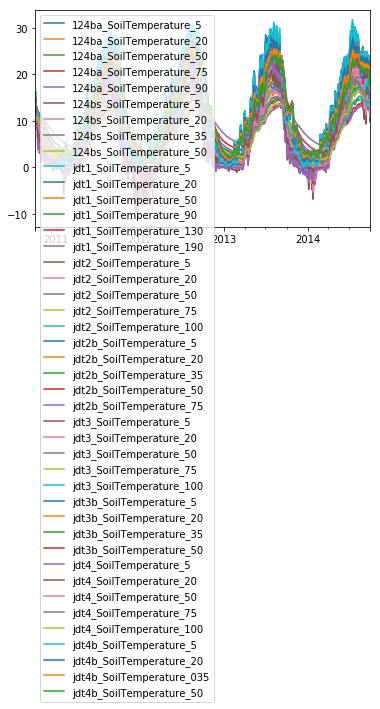

In [33]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] 
        
df = threC(df, 'SoilTemperature')
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head()

### 13. Isotope


# Result

In [34]:
result = pd.concat([Discharge, Precipitation, AirTemperature, RelativeHumidity, 
                    WindDirection, WindSpeed, SnowDepth, VaporPressure, 
                    SoilMoisture, SoilTemperature],
                    axis=1,
                    join='outer')
result.index.rename('DateTime',inplace = True)

In [35]:
result.head()

036_Discharge  046_Discharge  057_Discharge  098_Discharge  \
DateTime                                                                 
1962-01-01            NaN            NaN            NaN            NaN   
1962-01-02            NaN            NaN            NaN            NaN   
1962-01-03            NaN            NaN            NaN            NaN   
1962-01-04            NaN            NaN            NaN            NaN   
1962-01-05            NaN            NaN            NaN            NaN   

            116b_Discharge  117_Discharge  125b_Discharge  135_Discharge  \
DateTime                                                                   
1962-01-01             NaN            NaN             NaN            NaN   
1962-01-02             NaN            NaN             NaN            NaN   
1962-01-03             NaN            NaN             NaN            NaN   
1962-01-04             NaN            NaN             NaN            NaN   
1962-01-05             NaN            NaN             NaN            NaN   

            138012_Discharge  166_Discharge  ...  jdt3b_SoilTemperature_50  \
DateTime                                     ...                             
1962-01-01               NaN            NaN  ...                       NaN   
1962-01-02               NaN            NaN  ...                       NaN   
1962-01-03               NaN            NaN  ...                       NaN   
1962-01-04               NaN            NaN  ...                       NaN   
1962-01-05               NaN            NaN  ...                       NaN   

            jdt4_SoilTemperature_5  jdt4_SoilTemperature_20  \
DateTime                                                      
1962-01-01                     NaN                      NaN   
1962-01-02                     NaN                      NaN   
1962-01-03                     NaN                      NaN   
1962-01-04                     NaN                      NaN   
1962-01-05                     NaN                      NaN   

            jdt4_SoilTemperature_50  jdt4_SoilTemperature_75  \
DateTime                                                       
1962-01-01                      NaN                      NaN   
1962-01-02                      NaN                      NaN   
1962-01-03                      NaN                      NaN   
1962-01-04                      NaN                      NaN   
1962-01-05                      NaN                      NaN   

            jdt4_SoilTemperature_100  jdt4b_SoilTemperature_5  \
DateTime                                                        
1962-01-01                       NaN                      NaN   
1962-01-02                       NaN                      NaN   
1962-01-03                       NaN                      NaN   
1962-01-04                       NaN                      NaN   
1962-01-05                       NaN                      NaN   

            jdt4b_SoilTemperature_20  jdt4b_SoilTemperature_035  \
DateTime                                                          
1962-01-01                       NaN                        NaN   
1962-01-02                       NaN                        NaN   
1962-01-03                       NaN                        NaN   
1962-01-04                       NaN                        NaN   
1962-01-05                       NaN                        NaN   

            jdt4b_SoilTemperature_50  
DateTime                              
1962-01-01                       NaN  
1962-01-02                       NaN  
1962-01-03                       NaN  
1962-01-04                       NaN  
1962-01-05                       NaN  

[5 rows x 175 columns]

In [ ]:
table1=copy.deepcopy(result)
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == result.shape[1] :
    print('There are no empty columns!')

In [37]:
# Write data to csv for further inspection
table1.to_csv('1_Reynolds_Download_Aggregation_Daily.csv', sep=',')